# Using AWS Lambda and PyWren for Landsat 8 Time Series
This notebook is a simple demonstration of drilling a timeseries of NDVI values from the [Landsat 8 scenes held on AWS](https://landsatonaws.com/)

#### Credits
- NDVI PyWren - [Peter Scarth](mailto:p.scarth@uq.edu.au?subject=AWS%20Lambda%20and%20PyWren) (Joint Remote Sensing Research Program)
- [RemotePixel](https://github.com/RemotePixel/remotepixel-api) - Landsat 8 NDVI GeoTIFF parsing function
- [PyWren](https://github.com/pywren/pywren) - Project by BCII and riselab. Makes it easy to executive massive parallel map queries across [AWS Lambda](https://aws.amazon.com/lambda/)

#### Additional notes
The below remotely executed function will deliver results usually in under a minute for the full timeseries of more than 100 images, and we can simply plot the resulting timeseries or do further analysis. BUT, the points may well be cloud or cloud shadow contaminated. We haven’t done any cloud masking to the imagery, but we do have the scene metadata on the probable amount of cloud across the entire scene. We use this to weight a [smoothing spline](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.UnivariateSpline.html), such that an observation with no reported cloud over the scene has full weight, and an observation with a reported 100% of the scene with cloud has zero weight.  

# Step by Step instructions

### Setup Logging (optional)
Only activate the below lines if you want to see all debug messages from PyWren. _Note: The output will be rather chatty and lengthy._

In [ ]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
%env PYWREN_LOGLEVEL=INFO

### Setup all the necessary libraries
This will setup all the necessary libraries to properly display our results and it also imports the library that allows us to query Landsat 8 data from the [AWS Public Dataset](https://aws.amazon.com/public-datasets/landsat/):

In [ ]:
import requests, json, numpy, datetime, os, boto3
from IPython.display import HTML, display, Image
import matplotlib.pyplot as plt
import l8_ndvi
#import l8_full
#import l8_mosaic
from scipy.interpolate import UnivariateSpline
import pywren

# Function to return a Landsat 8 scene list given a Longitude,Latitude string
# This uses the amazing developmentseed Satellite API
# https://github.com/sat-utils/sat-api
def getSceneList(lonLat):
    scenes=[]
    url = "https://api.developmentseed.org/satellites/landsat"
    params = dict(
        contains=lonLat,
        satellite_name="landsat-8",
        limit="1000") 
    # Call the API to grab the scene metadata
    sceneMetaData = json.loads(requests.get(url=url, params=params).content)
    # Parse the metadata
    for record in sceneMetaData["results"]:
        scene = str(record['aws_index'].split('/')[-2]) 
        # This horrible hack is to get around some versioning problem on the API :(
        # I'd love to get this sorted out, probaby by hosting my own sat-api instance
        # Related to this issue https://github.com/sat-utils/sat-api/issues/18 
        if scene[-2:] == '01':
            scene = scene[:-2] + '00'
        if scene[-2:] == '02':
            scene = scene[:-2] + '00'
        if scene[-2:] == '03':
            scene = scene[:-2] + '02'
        scenes.append(scene)   
    return scenes


# Function to call a AWS Lambda function to drill a single pixel and compute the NDVI
# Replace the url here with the endpoint of your local function :)
def getNDVI(scene):
    #s = os.statvfs('/tmp')
    #logger.info("Remaining space: " + str(s.f_bsize * s.f_bavail))
    return l8_ndvi.point(scene, eval(lonLat))

def get_NDVI_api(scene):
    url = "https://w5xm4e5886.execute-api.us-west-2.amazonaws.com/production/l8_ndvi_point"
    params = dict(
        bbox=lonLat,
        scene=scene)
    # Call the API and return the JSON results
    resp = requests.get(url=url, params=params)
    return resp


### Run the code locally over a point of interest
Let's have a look at Hong Kong, an urban area with some country parks surrounding the city: [114.1095,22.3964](https://goo.gl/maps/PhDLAdLbiQT2)

First we need to retrieve the available Landsat 8 scenes from the point of interest:

In [2]:
lonLat = '114.1095,22.3964'
scenesHK = getSceneList('114.1095,22.3964')
print(scenesHK)
display(HTML('Total scenes: <b>' + str(len(scenesHK)) + '</b>'))

['LC08_L1GT_122044_20171108_20171108_01_RT', 'LC08_L1GT_122045_20171108_20171108_01_RT', 'LC08_L1TP_121045_20171101_20171109_01_T1', 'LC08_L1TP_121044_20171101_20171109_01_T1', 'LC08_L1TP_122045_20171023_20171107_01_T1', 'LC08_L1TP_122044_20171023_20171107_01_T1', 'LC08_L1GT_121044_20171016_20171024_01_T2', 'LC08_L1TP_121045_20171016_20171024_01_T1', 'LC08_L1TP_122044_20171007_20171023_01_T1', 'LC08_L1TP_122045_20171007_20171023_01_T1', 'LC08_L1TP_121045_20170930_20171013_01_T1', 'LC08_L1TP_121044_20170930_20171013_01_T1', 'LC08_L1TP_122045_20170921_20171012_01_T1', 'LC08_L1TP_122044_20170921_20171012_01_T1', 'LC08_L1TP_121044_20170914_20170928_01_T1', 'LC08_L1TP_121045_20170914_20170928_01_T1', 'LC08_L1TP_122045_20170905_20170916_01_T1', 'LC08_L1TP_122044_20170905_20170916_01_T1', 'LC08_L1TP_121045_20170829_20170914_01_T1', 'LC08_L1TP_121044_20170829_20170914_01_T1', 'LC08_L1TP_122045_20170820_20170826_01_T1', 'LC08_L1TP_122044_20170820_20170826_01_T1', 'LC08_L1TP_121045_20170813_2017

Now let's find out the NDVI and the amount of clouds on a specific scene:

In [3]:
lonLat = '114.1095,22.3964'
thumbnail = l8_ndvi.thumb('LC08_L1TP_121045_20170829_20170914_01_T1', eval(lonLat))
display(Image(url=thumbnail, format='jpg'))
result = getNDVI('LC08_L1TP_121045_20170829_20170914_01_T1')
#display(result)
display(HTML('<b>Date:</b> '+result['date']))
display(HTML('<b>Amount of clouds:</b> '+str(result['cloud'])+'%'))
display(HTML('<b>NDVI:</b> '+str(result['ndvi'])))

Great, time to try this with an observation on a cloudier day. Please note that the NDVI drops too, as we are not able to actually receive much data fom the land surface:

In [4]:
lonLat = '114.1095,22.3964'
thumbnail = l8_ndvi.thumb('LC08_L1GT_122044_20171108_20171108_01_RT', eval(lonLat))
display(Image(url=thumbnail, format='jpg'))
result = getNDVI('LC08_L1GT_122044_20171108_20171108_01_RT')
#display(result)
display(HTML('<b>Date:</b> '+result['date']))
display(HTML('<b>Amount of clouds:</b> '+str(result['cloud'])+'%'))
display(HTML('<b>NDVI:</b> '+str(result['ndvi'])))

### Massively Parallel calculation with PyWren

Now let's try this with multiple scenes and send it to PyWren, however to accomplish this we need to change our PyWren AWS Lambda function to include the necessary libraries such as rasterio and GDAL. Since those libraries are compiled C code, PyWren will not be able to pickle it up and send it to the Lambda function. Hence we will update the entire PyWren function to include the necessary binaries that have been compiled on an Amazon EC2 instance with Amazon Linux. We pre-packaged this and made it available via https://s3-us-west-2.amazonaws.com/pywren-workshop/lambda_function.zip

You can simple push this code to your PyWren AWS Lambda function with below command, assuming you named the function with the default name pywren_1 and region us-west-2:

In [ ]:
lambdaclient = boto3.client('lambda', 'us-west-2')

response = lambdaclient.update_function_code(
    FunctionName='pywren_1',
    Publish=True,
    S3Bucket='pywren-workshop',
    S3Key='lambda_function.zip'
)
display(response)

response = lambdaclient.update_function_configuration(
    FunctionName='pywren_1',
    Environment={
        'Variables': {
            'GDAL_DATA': '/var/task/lib/gdal'
        }
    }
)
display(response)

If you look at the list of available scenes, we have a rather large amount. This is a good use-case for PyWren as it will allows us to have AWS Lambda perform the calculation of NDVI and clouds for us - furthermore it will have a faster connectivity to read and write from Amazon S3.

Ok let's try this on the latest 200 collected Landsat 8 images GeoTIFFs of Hong Kong:

In [6]:
lonLat = '114.1095,22.3964'
pwex = pywren.default_executor()
resultsHK = pywren.get_all_results(pwex.map(getNDVI, scenesHK[:200]))
display(resultsHK)

[{'cloud': 99.95,
  'date': '2017-11-08',
  'ndvi': 0.089643054,
  'scene': 'LC08_L1GT_122044_20171108_20171108_01_RT'},
 {'cloud': 97.37,
  'date': '2017-11-08',
  'ndvi': 0.0,
  'scene': 'LC08_L1GT_122045_20171108_20171108_01_RT'},
 {'cloud': 24.3,
  'date': '2017-11-01',
  'ndvi': 0.43690208,
  'scene': 'LC08_L1TP_121045_20171101_20171109_01_T1'},
 {},
 {'cloud': 12.31,
  'date': '2017-10-23',
  'ndvi': 0.0,
  'scene': 'LC08_L1TP_122045_20171023_20171107_01_T1'},
 {'cloud': 0.05,
  'date': '2017-10-23',
  'ndvi': 0.51073694,
  'scene': 'LC08_L1TP_122044_20171023_20171107_01_T1'},
 {},
 {'cloud': 11.37,
  'date': '2017-10-16',
  'ndvi': 0.017148329,
  'scene': 'LC08_L1TP_121045_20171016_20171024_01_T1'},
 {'cloud': 49.73,
  'date': '2017-10-07',
  'ndvi': 0.51883012,
  'scene': 'LC08_L1TP_122044_20171007_20171023_01_T1'},
 {'cloud': 36.43,
  'date': '2017-10-07',
  'ndvi': 0.0,
  'scene': 'LC08_L1TP_122045_20171007_20171023_01_T1'},
 {'cloud': 35.37,
  'date': '2017-09-30',
  'ndvi':

### Display results
Let's try to render our results in a nice HTML table first:

In [7]:
#Remove results where we couldn't retrieve data from the scene 
results = filter(None, resultsHK)

#Render a nice HTML table to display result
html = '<table><tr><td><b>Date</b></td><td><b>Clouds</b></td><td><b>NDVI</b></td></tr>'
for x in results:    
    html = html + '<tr>'
    html = html + '<td>' + x['date'] + '</td>'
    html = html + '<td>' + str(x['cloud']) + '%</td>'
    html = html + '<td '
    if (x['ndvi'] > 0.5):
        html = html + ' bgcolor="#00FF00">'
    elif (x['ndvi'] > 0.1):
        html = html + ' bgcolor="#FFFF00">'
    else:
        html = html + ' bgcolor="#FF0000">'
    html = html + str(round(abs(x['ndvi']),2)) + '</td>'
    html = html + '</tr>'
html = html + '</table>'
display(HTML(html))


Date,Clouds,NDVI
2017-11-08,99.95%,0.09
2017-11-08,97.37%,0.0
2017-11-01,24.3%,0.44
2017-10-23,12.31%,0.0
2017-10-23,0.05%,0.51
2017-10-16,11.37%,0.02
2017-10-07,49.73%,0.52
2017-10-07,36.43%,0.0
2017-09-30,35.37%,0.0
2017-09-30,40.27%,0.0


This provides us a good overview but would quickly become difficult to read as the datapoints expand - let's use [Matplotlib](https://matplotlib.org/) instead to plot this out:

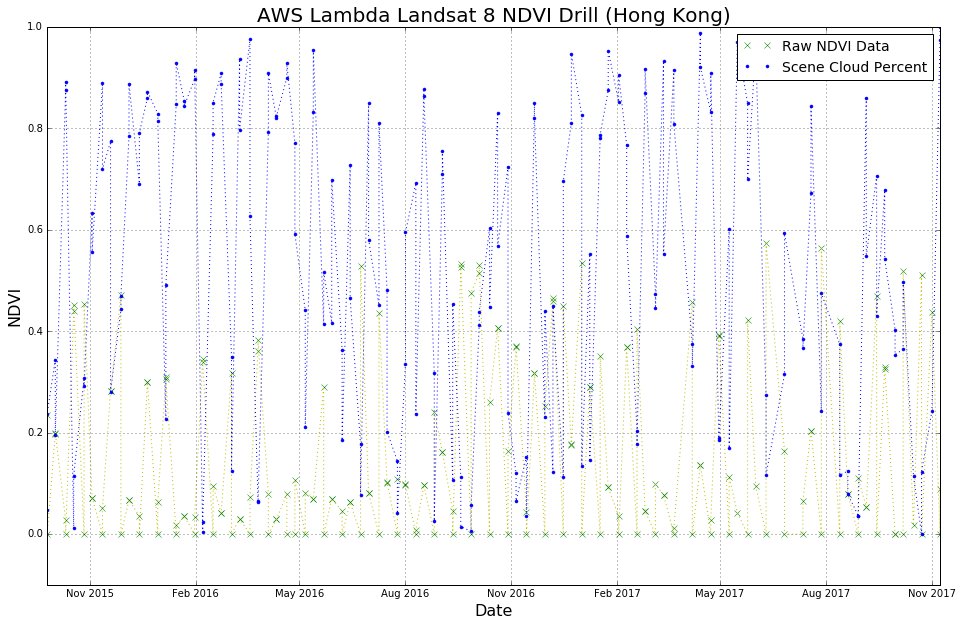

In [8]:
timeSeries = filter(None,resultsHK)

# Extract the data trom the list of results
timeStamps = [datetime.datetime.strptime(obs['date'],'%Y-%m-%d') for obs in timeSeries if 'date' in obs]
ndviSeries = [obs['ndvi'] for obs in timeSeries if 'ndvi' in obs]
cloudSeries = [obs['cloud']/100 for obs in timeSeries if 'cloud' in obs]

# Create a time variable as the x axis to fit the observations
# First we convert to seconds
timeSecs = numpy.array([(obsTime-datetime.datetime(1970,1,1)).total_seconds() for obsTime in timeStamps])
# And then normalise from 0 to 1 to avoid any numerical issues in the fitting
fitTime = ((timeSecs-numpy.min(timeSecs))/(numpy.max(timeSecs)-numpy.min(timeSecs)))

# Smooth the data by fitting a spline weighted by cloud amount
smoothedNDVI=UnivariateSpline(
    fitTime[numpy.argsort(fitTime)],
    numpy.array(ndviSeries)[numpy.argsort(fitTime)],
    w=(1.0-numpy.array(cloudSeries)[numpy.argsort(fitTime)])**2.0,
    k=2,
    s=0.1)(fitTime)

fig = plt.figure(figsize=(16,10))
plt.plot(timeStamps,ndviSeries, 'gx',label='Raw NDVI Data')
plt.plot(timeStamps,ndviSeries, 'y:', linewidth=1)
plt.plot(timeStamps,cloudSeries, 'b.', linewidth=1,label='Scene Cloud Percent')
plt.plot(timeStamps,cloudSeries, 'b:', linewidth=1)
#plt.plot(timeStamps,smoothedNDVI, 'r--', linewidth=3,label='Cloudfree Weighted Spline')
plt.xlabel('Date', fontsize=16)
plt.ylabel('NDVI', fontsize=16)
plt.title('AWS Lambda Landsat 8 NDVI Drill (Hong Kong)', fontsize=20)
plt.grid(True)
plt.ylim([-.1,1.0])
plt.legend(fontsize=14)
plt.show()

### Run the code over another location
This test site is a cotton farming area in Queensland, Australia [147.870599,-28.744617](https://goo.gl/maps/GF5szf7vZo82)

Let's first acquire some scenes:

In [9]:
lonLat = '147.870599,-28.744617'
scenesQLD = getSceneList(lonLat)
print(scenesQLD)
display(HTML('Total scenes: <b>' + str(len(scenesQLD)) + '</b>'))


['LC08_L1TP_092080_20171106_20171106_01_RT', 'LC08_L1TP_092080_20171021_20171106_01_T1', 'LC08_L1TP_092080_20171005_20171014_01_T1', 'LC08_L1TP_092080_20170919_20170929_01_T1', 'LC08_L1TP_092080_20170903_20170916_01_T1', 'LC08_L1TP_092080_20170818_20170826_01_T1', 'LC08_L1TP_092080_20170802_20170812_01_T1', 'LC08_L1TP_092080_20170717_20170727_01_T1', 'LC08_L1TP_092080_20170701_20170715_01_T1', 'LC08_L1TP_092080_20170615_20170628_01_T1', 'LC08_L1TP_092080_20170530_20170615_01_T1', 'LC08_L1TP_092080_20170514_20170525_01_T1', 'LC80920802017118LGN00', 'LC80920802017102LGN00', 'LC80920802017086LGN00', 'LC80920802017070LGN00', 'LC80920802017054LGN00', 'LC80920802017038LGN00', 'LC80920802017022LGN00', 'LC80920802017006LGN00', 'LC80920802016356LGN00', 'LC80920802016340LGN00', 'LC80920802016324LGN00', 'LC80920802016308LGN00', 'LC80920802016292LGN00', 'LC80920802016276LGN00', 'LC80920802016260LGN00', 'LC80920802016244LGN00', 'LC80920802016228LGN00', 'LC80920802016212LGN00', 'LC80920802016196LGN0

Let's first have a look at an individual observation first on our local machine:

In [10]:
thumbnail = l8_ndvi.thumb('LC80920802017118LGN00', eval(lonLat))
display(Image(url=thumbnail, format='jpg'))
result = getNDVI('LC80920802017118LGN00')
#display(result)
display(HTML('<b>Date:</b> '+result['date']))
display(HTML('<b>Amount of clouds:</b> '+str(result['cloud'])+'%'))
display(HTML('<b>NDVI:</b> '+str(result['ndvi'])))


### Pywren Time
Let's process this across all of the observations in parallel using AWS Lambda:

In [11]:
pwex = pywren.default_executor()
resultsQLD = pywren.get_all_results(pwex.map(getNDVI, scenesQLD))
display(resultsQLD)

[{'cloud': 25.11,
  'date': '2017-11-06',
  'ndvi': 0.17174406,
  'scene': 'LC08_L1TP_092080_20171106_20171106_01_RT'},
 {'cloud': 90.42,
  'date': '2017-10-21',
  'ndvi': 0.034937914,
  'scene': 'LC08_L1TP_092080_20171021_20171106_01_T1'},
 {'cloud': 10.3,
  'date': '2017-10-05',
  'ndvi': 0.16075833,
  'scene': 'LC08_L1TP_092080_20171005_20171014_01_T1'},
 {'cloud': 0.0,
  'date': '2017-09-19',
  'ndvi': 0.15574218,
  'scene': 'LC08_L1TP_092080_20170919_20170929_01_T1'},
 {'cloud': 6.63,
  'date': '2017-09-03',
  'ndvi': 0.15472522,
  'scene': 'LC08_L1TP_092080_20170903_20170916_01_T1'},
 {'cloud': 0.0,
  'date': '2017-08-18',
  'ndvi': 0.15092808,
  'scene': 'LC08_L1TP_092080_20170818_20170826_01_T1'},
 {'cloud': 0.0,
  'date': '2017-08-02',
  'ndvi': 0.14579444,
  'scene': 'LC08_L1TP_092080_20170802_20170812_01_T1'},
 {'cloud': 3.84,
  'date': '2017-07-17',
  'ndvi': 0.15653011,
  'scene': 'LC08_L1TP_092080_20170717_20170727_01_T1'},
 {'cloud': 0.0,
  'date': '2017-07-01',
  'ndvi'

Now let's plot this out again:

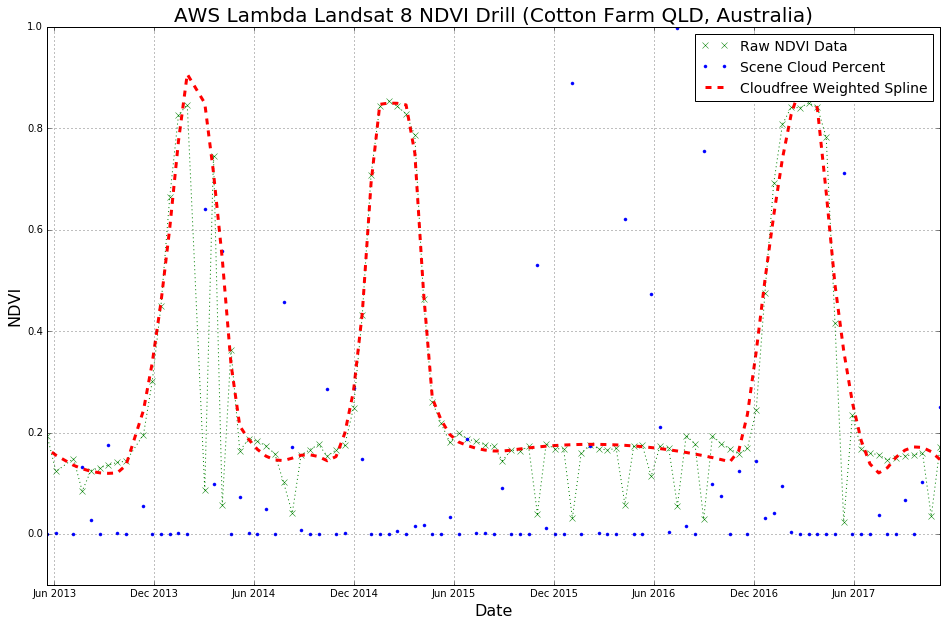

In [12]:
timeSeries = filter(None,resultsQLD)

# Extract the data trom the list of results
timeStamps = [datetime.datetime.strptime(obs['date'],'%Y-%m-%d') for obs in timeSeries if 'date' in obs]
ndviSeries = [obs['ndvi'] for obs in timeSeries if 'ndvi' in obs]
cloudSeries = [obs['cloud']/100 for obs in timeSeries if 'cloud' in obs]

# Create a time variable as the x axis to fit the observations
# First we convert to seconds
timeSecs = numpy.array([(obsTime-datetime.datetime(1970,1,1)).total_seconds() for obsTime in timeStamps])
# And then normalise from 0 to 1 to avoid any numerical issues in the fitting
fitTime = ((timeSecs-numpy.min(timeSecs))/(numpy.max(timeSecs)-numpy.min(timeSecs)))

# Smooth the data by fitting a spline weighted by cloud amount
smoothedNDVI=UnivariateSpline(
    fitTime[numpy.argsort(fitTime)],
    numpy.array(ndviSeries)[numpy.argsort(fitTime)],
    w=(1.0-numpy.array(cloudSeries)[numpy.argsort(fitTime)])**2.0,
    k=2,
    s=0.1)(fitTime)


fig = plt.figure(figsize=(16,10))
plt.plot(timeStamps,ndviSeries, 'gx',label='Raw NDVI Data')
plt.plot(timeStamps,ndviSeries, 'g:', linewidth=1)
plt.plot(timeStamps,cloudSeries, 'b.', linewidth=1,label='Scene Cloud Percent')
plt.plot(timeStamps,smoothedNDVI, 'r--', linewidth=3,label='Cloudfree Weighted Spline')
plt.xlabel('Date', fontsize=16)
plt.ylabel('NDVI', fontsize=16)
plt.title('AWS Lambda Landsat 8 NDVI Drill (Cotton Farm QLD, Australia)', fontsize=20)
plt.grid(True)
plt.ylim([-.1,1.0])
plt.legend(fontsize=14)
plt.show()